# Mini-Challenge 2: Image Capting

Firat Saritas, 24.12.2021

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import seaborn as sns
from tqdm import tqdm
from matplotlib.pyplot import figure
from collections import Counter
import nltk #for tokenization 
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms

from torchvision import transforms
import torchvision
from PIL import Image
from matplotlib import pyplot

## Ausgangslage:

## 1. Daten

In [2]:
data_location =  "data/Flickr_8k/Images/"
caption_location =  "data/Flickr_8k/captions.txt"

In [3]:
df_captions = pd.read_csv(caption_location, sep=',')
df_captions.head(10)

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

In [4]:
volume = os.listdir(data_location)
print("\nAnzahl Bilder: {}".format(len(volume)))


Anzahl Bilder: 8091


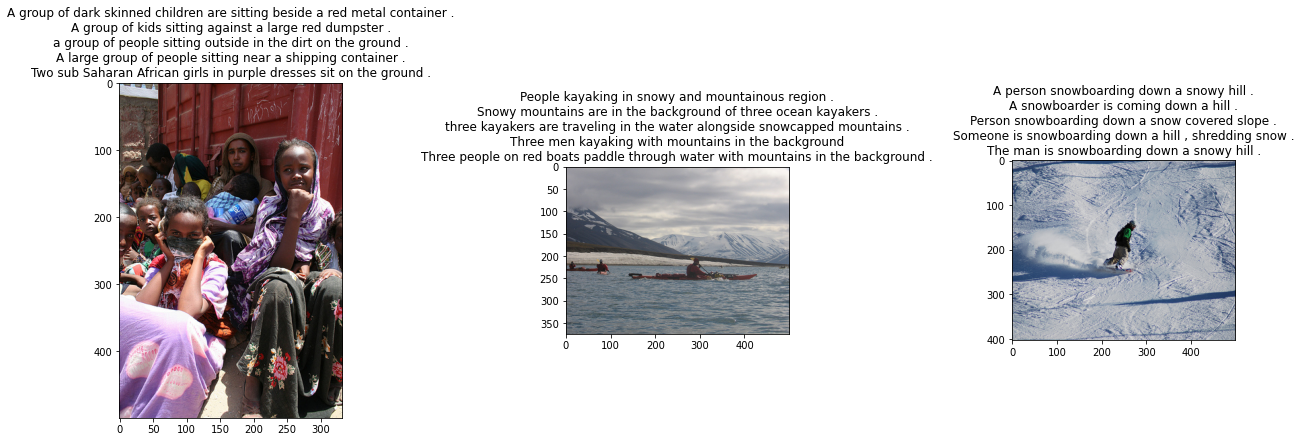

In [5]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=1)
k = 0
random.seed(88)

for i in range(3):
    random_number = random.randint(0, len(df_captions))
    sample = df_captions.iloc[random_number][0]
    sample_path =data_location+sample
    sample_images = df_captions[df_captions['image'] == sample]
    sample_captions = sample_images['caption'].tolist()    
    img=mpimg.imread(sample_path)
    ax=plt.subplot(1,3,k+1)
    ax.title.set_text(sample_captions[0]+ "\n"+ sample_captions[1]+ "\n"+ sample_captions[2]+ "\n"+ sample_captions[3]+ "\n"+ sample_captions[4])
    plt.imshow(img)
    k = k+1    
    

Die Daten stammen von Kaggle und bestehen ca. aus 8'000 Bildern. Die Bilder sind jeweils mit fünf verschiedenen Bildunterschriften gepaart. Bei unseren drei zufälligen Beispielen sehen wir, dass wir unterschiedliche Formate der Bilder haben. Die Sätze beschreiben die Bilder andersartig und gut auf englisch.

In [6]:
cound_df = pd.DataFrame(df_captions.caption.str.split(expand=True).stack().value_counts())
cound_df = cound_df.rename(columns={0:"count"})
cound_df.head(10)

count
a     40319
.     36577
A     22667
in    18962
the   15328
on    10730
is     9345
and    8850
dog    7984
with   7760

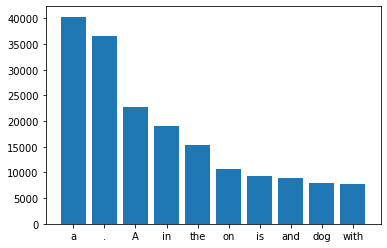

In [7]:
plt.bar(list(cound_df.index)[:10], list(cound_df.head(10).iloc[:,0]))
plt.show()

Wie erwartet sind die häufigsten Wörten die sogenanten "Stopwords". Stopwords sind Wörter, die einem Satz nicht viel Bedeutung hinzufügen. Sie können ignoriert werden, ohne gross die Bedeutung des Satzes zu beeinträchtigen.

## 2. Aufbau Modelierung

In [8]:
import torch

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
device

NVIDIA GeForce RTX 3060


device(type='cuda')

### 2.1. Data Loader

In [10]:
# Index all Words
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"} #UNK is Unknown. 
        self.stoi = {"<PAD>": 0, "<SOS>" : 1, "<EOS>": 2, "<UNK>": 3} #stoi= string to index, itos = index to string
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        tt = text.lower()
        return nltk.word_tokenize(tt)

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4 #because we have 4 defined further up
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                    
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [11]:
class FlickrDataset(Dataset):
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
        
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]] #SOS = Start of Sentence
        caption_vec += self.vocab.numericalize(caption)
        caption_vec.append(self.vocab.stoi["<EOS>"]) #EOS = End of Sentence
        
        return img, torch.tensor(caption_vec)

In [12]:
#ped all to the same length
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [13]:
def image_loader(data_location,caption_location,batch_size=32,num_workers=8,image_size=32,shuffle=True,pin_memory=False):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    dataset = FlickrDataset(data_location, caption_location, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    dataloader = DataLoader(dataset=dataset,batch_size=batch_size,num_workers=num_workers,
        shuffle=shuffle,pin_memory=pin_memory,collate_fn=MyCollate(pad_idx=pad_idx))

    return dataset, dataloader

In [14]:
#setting the constants
batch_size = 32
num_workers = 0
image_size=224

In [15]:
dataset,dataloader = image_loader(data_location=data_location,
                                    caption_location=caption_location,
                                    batch_size = batch_size,
                                    num_workers=num_workers,
                                    image_size=image_size)

In [16]:
def main():
    stopper = 1
    counter = 0
    for index, (imgs, captions) in enumerate(dataloader):
            print(imgs.shape)
            print(captions.shape)
            counter += 1
            if counter == stopper:
                break
if __name__ == "__main__":
    main()        

torch.Size([32, 3, 224, 224])
torch.Size([21, 32])


Im Output sehen wir folgendes:
- die 32 steht für die Batchgrösse. Somit habven wir 16 Beispiele pro batch
- die 3 steht für die 3 farben RGB.
- die beiden Zahlen 224 stehen für die Grösse des Bildes.
- die 20 steht für maximale länge der Batch-Sequenz.

In [17]:
vocab_size = len(dataset.vocab)
vocab_size

3005

### 2.2 Defining the Model Architecture

In [18]:
resnet = models.resnet50(pretrained=True)
googlenet =  models.googlenet(pretrained=True)

#CNN resnet
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = resnet

    def forward(self, images):
        features = self.inception(images)
        return features
    
#CNN googlenet
class EncoderCNNg(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNNg, self).__init__()
        self.train_CNN = train_CNN
        self.inception = googlenet

    def forward(self, images):
        features = self.inception(images)
        return features    

Für den CNN-Architektur nehmen wir das Netzwerk von resnet50. Dieses besteht aus 50 neuronalen Netzwerkschichten. Resnet ist einer der beliebtesten Modelle im Bereich Image Recognition.

In [19]:
#RNN
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers) #lstm = Long short-term memory
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [20]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers,network):
        super(CNNtoRNN, self).__init__()
        if network == "googlenet":
            self.encoderCNN = EncoderCNNg(embed_size)
        else:
            self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[index] for index in result_caption]

### Training

In [21]:
transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [22]:
def predict(model, device, dataset, img):
    model.eval()
    test_img = transform(Image.open(img).convert("RGB")).unsqueeze(0)
    pred_token = model.caption_image(test_img.to(device), dataset.vocab)
    pred_token = pred_token[1:-1]
    return " ".join(pred_token)

In [23]:
def train(learning_rate = 3e-4, num_epochs = 5,network="resnet"):
    losses = []
    # Hyperparameters
    embed_size = 1000
    hidden_size = 256
    num_layers = 1

    # for tensorboard
    #writer = SummaryWriter("runs/flickr")
    #step = 0

    # initialize model and loss
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers,network).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Only finetune the CNN
    for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
    model.train()

    for epoch in range(num_epochs):
        print("Epoch {}".format(epoch+1))
        acc_loss = 0.
        for idx, (imgs, captions) in tqdm(
            enumerate(dataloader), total=len(dataloader), leave=False
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1]) #last one open, bc we want to predict them
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
            #writer.add_scalar("Training loss", loss.item(), global_step=step)
            #step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
            acc_loss += loss
        losses.append(acc_loss / 1265)        

    
    return model,losses
    

In [24]:
r_model,r_losses = train(learning_rate = 0.0003, num_epochs = 10,network="resnet")

Epoch 1


Epoch 2


Epoch 3


Epoch 4


Epoch 5


Epoch 6


Epoch 7


Epoch 8


Epoch 9


Epoch 10


In [25]:
g_model,g_losses = train(learning_rate = 0.0003, num_epochs = 10,network="googlenet")

Epoch 1


Epoch 2


Epoch 3


Epoch 4


Epoch 5


Epoch 6


Epoch 7


Epoch 8


Epoch 9


Epoch 10


<Figure size 432x288 with 0 Axes>

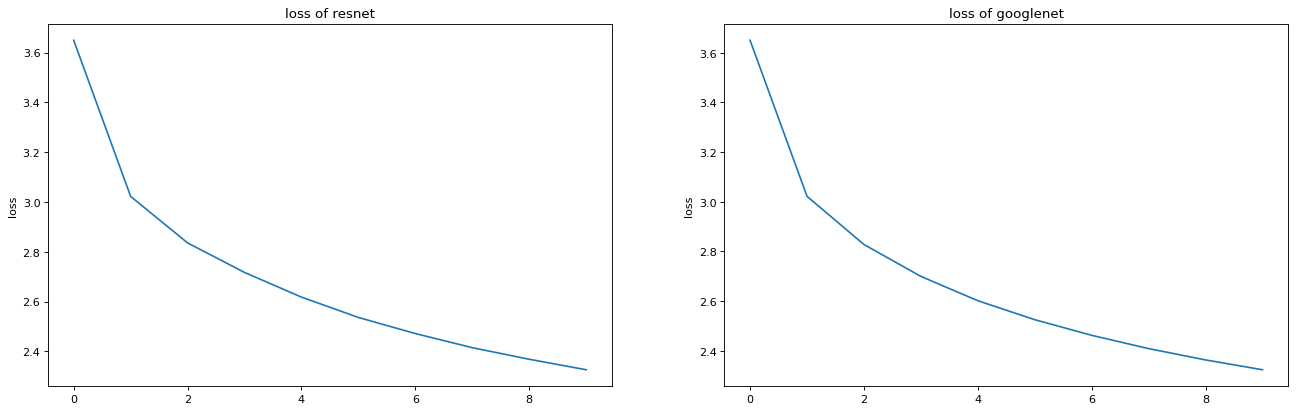

In [26]:
float_r_losses = []
for i in range(len(r_losses)):
    float_r_losses.append(r_losses[i].item())
float_g_losses = []
for i in range(len(g_losses)):
    float_g_losses.append(g_losses[i].item())

pyplot.figure()
figure(figsize=(20, 6), dpi=80)
# sp1
pyplot.subplot(121)
plt.plot(float_r_losses)
plt.ylabel("loss")
plt.title("loss of resnet")

# sp2
pyplot.subplot(122)
plt.plot(float_g_losses)
plt.ylabel("loss")
plt.title("loss of googlenet")
plt.show()

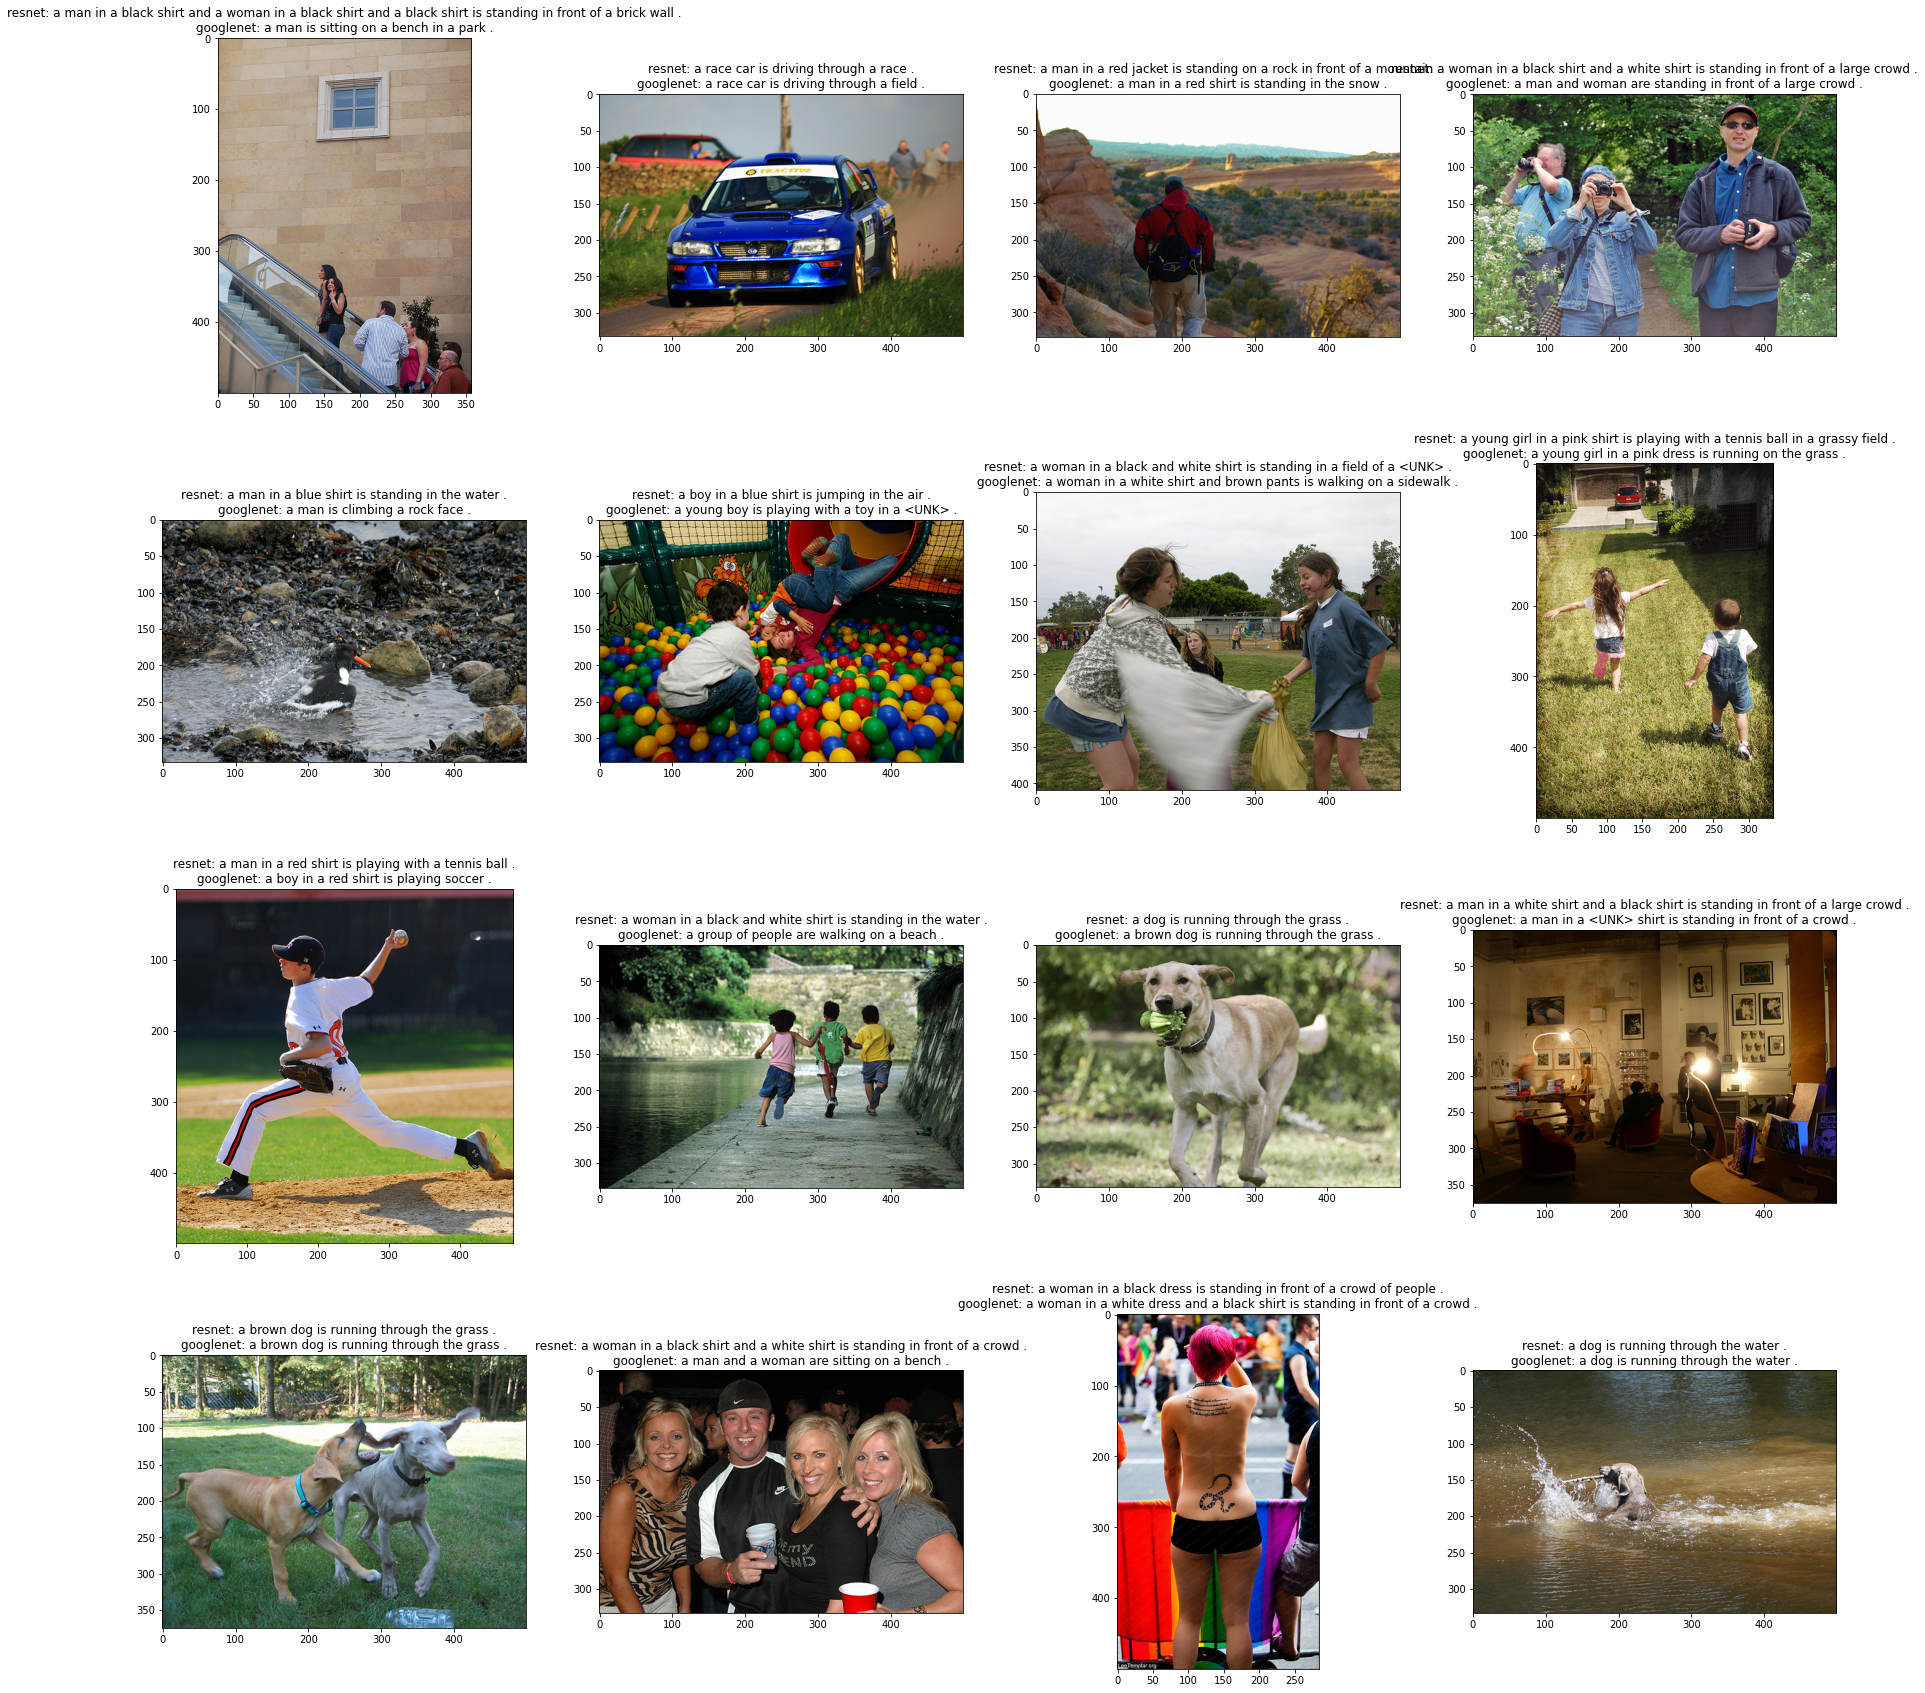

In [31]:
plt.figure(figsize=(30,30))
#plt.subplots_adjust(wspace=1)
k = 0
for i in range(16):
    random_number = random.randint(0, len(df_captions))
    sample = df_captions.iloc[random_number][0]
    sample_path =data_location+sample
    sample_images = df_captions[df_captions['image'] == sample]
    r_pred=predict(r_model, device, dataset, img=sample_path)
    g_pred=predict(g_model, device, dataset, img=sample_path)
    img=mpimg.imread(sample_path)
    ax=plt.subplot(4,4,k+1)
    ax.title.set_text("resnet: {}\ngooglenet: {}".format(r_pred,g_pred))
    plt.imshow(img)
    k = k+1   


### BLEU-Score

BLEU steht für «Bilingual Evaluation Understudy» misst in einfachen Worten den Unterschied zwischen menschliche und maschinelle Übersetzung. Dabei wir ein recht simpler Algorithmus verwendet. Es wird der vom Modell vorhergesagt Satz genommen und mit dem vom Menschen definierten Sätze verglichen. Umso näher die vorhersage zum eigentlichen Satz, desto besser der Score. Die Skala vom BLEU-Score liegt von 0 bis 1. Ein Score von 1 wäre eine perfekte vorhersage. Dennoch bringt dieser Algorithmus gewisse Nachteile mit sich: Es ist schwierig eine maschinelle Übersetzung zu vergleichen, wenn es nicht nur eine richtige Antwort gibt. Zudem kann man mit dem BLEU Score nicht die Wichtigkeit eines Fehlers bewerten. Somit ist jedes Wort gleichgewichtet was eigentlich ein nicht idealer Ansatz ist.

In [32]:
from nltk.translate.bleu_score import sentence_bleu

In [46]:
def random_pic():
    random_number = random.randint(0, len(df_captions))
    sample = df_captions.iloc[random_number][0]
    sample_path =data_location+sample
    sample_images = df_captions[df_captions['image'] == sample]
    sample_captions = sample_images['caption'].tolist()    
    img=mpimg.imread(sample_path)
    plt.title(sample_captions[0]+ "\n"+ sample_captions[1]+ "\n"+ sample_captions[2]+ "\n"+ sample_captions[3]+ "\n"+ sample_captions[4])
    plt.imshow(img)
    r_pred=predict(r_model, device, dataset, img=sample_path)
    g_pred=predict(g_model, device, dataset, img=sample_path)
    reference = [sample_captions[1].split(),sample_captions[2].split(),sample_captions[3].split(),sample_captions[4].split()]
    r_candidate = r_pred.split()
    g_candidate = g_pred.split()
    r_score = sentence_bleu(reference, r_candidate, weights=(0, 1, 0, 0))
    g_score = sentence_bleu(reference, g_candidate, weights=(0, 1, 0, 0))
    
    print("Predicion resnet: {}".format(r_pred))    
    print("BLEU Score: {}\n".format(np.round(r_score,2)))
    print("Predicion googlenet: {}".format(g_pred))    
    print("BLEU Score: {}".format(np.round(g_score,2)))

Predicion resnet: a young girl in a pink shirt is running through the grass .
BLEU Score: 0.67

Predicion googlenet: a little girl in a pink shirt is running through a field .
BLEU Score: 0.33


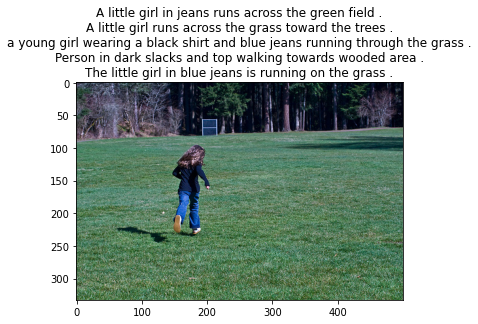

In [52]:
random_pic()

Predicion resnet: a dog is running through the grass .
BLEU Score: 0.13

Predicion googlenet: a dog is running through a field of grass .
BLEU Score: 0.15


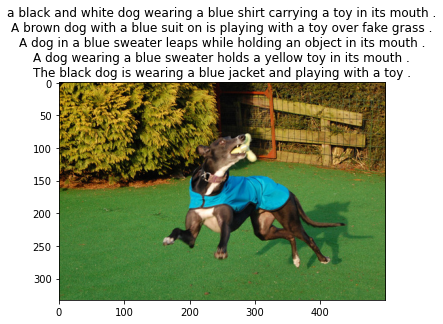

In [54]:
random_pic()

Predicion resnet: a black dog is running through the grass .
BLEU Score: 0.25

Predicion googlenet: a black dog is running through the grass .
BLEU Score: 0.25


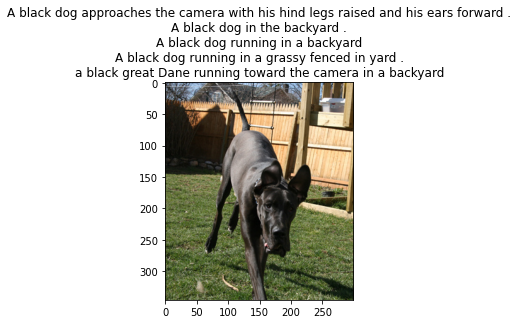

In [56]:
random_pic()

## 5. Quellenangaben
- https://www.kaggle.com/adityajn105/flickr8k
- https://www.kaggle.com/mdteach/image-captioning-with-attention-pytorch
- https://www.kaggle.com/mdteach/torch-data-loader-flicker-8k
- https://www.youtube.com/watch?v=9sHcLvVXsns&ab_channel=AladdinPersson
- https://www.youtube.com/watch?v=y2BaTt1fxJU&ab_channel=AladdinPersson
- https://viso.ai/deep-learning/resnet-residual-neural-network/
- https://www.lengoo.com/de-de/blog/mt-for-beginners-was-sind-bleu-scores/